In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
import os
import glob
import time
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import emoji

**Function to get the maze from website**

In [2]:
def get_maze(PATH, DOWNLOAD_PATH):
    # Set the download path
    # https://stackoverflow.com/a/43789674
    chrome_options = webdriver.ChromeOptions()
    prefs = {'download.default_directory' : DOWNLOAD_PATH}
    chrome_options.add_experimental_option('prefs', prefs)

    # Create the driver
    driver = webdriver.Chrome(executable_path=PATH, options=chrome_options)

    # Open the page
    driver.get('http://www.mazegenerator.net/')

    # Insert the width of the maze
    maze_width = '5'
    width = driver.find_element(By.ID, "S1WidthTextBox")
    width.clear()
    width.send_keys(maze_width)

    # Insert the height of the maze
    maze_height = '5'
    height = driver.find_element(By.ID, "S1HeightTextBox")
    height.clear()
    height.send_keys(maze_height + Keys.ENTER)

    # Choose the appropriate format to export
    # https://stackoverflow.com/a/28613320
    format_list = Select(driver.find_element(By.ID, 'FileFormatSelectorList'))
    format_list.select_by_value('9')

    # Download the file
    download = driver.find_element(By.ID, 'DownloadFileButton')
    download.click()

    # Wait 3 seconds to let the download finish
    time.sleep(3)

    # Close the window
    driver.quit()

## Class to create the environment and take actions

In [3]:
class MazeSolver():
    def __init__(self, PATH, DOWNLOAD_PATH):
        self.path = PATH
        self.download_path = DOWNLOAD_PATH
        self.get_environment()

    def get_environment(self):
        downloaded_files = self.download_path + '\*'

        # Delete any old files
        # https://stackoverflow.com/a/5756937
        files = glob.glob(downloaded_files)
        for f in files:
            os.remove(f)

        # Download a new maze
        get_maze(PATH=self.path, DOWNLOAD_PATH=self.download_path)

        # Get current file name for the image
        files = glob.glob(downloaded_files)
        for f in files:
            file_name = f

        # Rename the file
        NEW_NAME = self.download_path + '\maze.png'
        os.rename(file_name, NEW_NAME)

        # Plot the maze
        # https://matplotlib.org/2.0.2/users/image_tutorial.html
        img = mpimg.imread(NEW_NAME)
        plt.title('New Maze')
        plt.imshow(img)
        
        # Convert the maze to binary digits
        # https://stackoverflow.com/a/57614336
        im_to_convert = Image.open(NEW_NAME).convert('L')

        # Ensure all black pixels are 0 and all white pixels are 1
        binary = im_to_convert.point(lambda p: p > 128 and 1)

        # Convert to NumPy array
        im_array = np.array(binary)

        # Replace 1s with 0s
        path = np.where(im_array==1, 0, 1)
        path[0:2, 34:48] = 7

        # Reward of -1 with each step and...
        # Reward of -3 when agent bumps into a wall
        im = np.where(im_array==1, -1, -3)
        
        # Reward of 50 at terminal state
        im[0:2, 34:48] = 50
        
        # Reward environment (Actual environment to be used by the agent)
        self.environment = im
        
        # Path environment
        self.path = path
        
        # Reset environment
        self.reset = np.copy(path)

    
    def reset_env(self):
        agent.path = np.copy(agent.reset)
        
    def step(self, combined, action):  
        # Separate the number to get the row and column
        row, col = separate(combined)
        
        # Actions the agent can take
        up = self.environment[row-1, col] 
        down =  self.environment[row+1, col]
        left = self.environment[row, col-1] 
        right = self.environment[row, col+1]

        actions = [up, down, left, right]

        # Reward from action taken
        reward = actions[action]

        # If agent hits wall, stay in the same place
        if reward == -3:
            row, col = row, col
            
        # Else, update row and column
        elif reward >= -1:
            # Move up
            if action == 0 and row > 1:
                row, col =  row-1, col
                
            # Move down
            elif action == 1 and row < 80:
                row, col =  row+1, col
                
            # Move left
            elif action == 2 and col > 1:
                row, col = row, col-1
                
            # Move right
            elif action == 3 and col < 80:  
                row, col = row, col+1
                
            # Stay in the same state if move towards border
            else:
                row, col = row, col
        else:
            print('There may be a mistake')
            
            
        # Mark where the agent has traveled with a number 5
        self.path[row, col] = 5
        
        # Combine the row and column again
        combined = combine(row, col)
        
        return combined, reward

**Instantiate the Class**

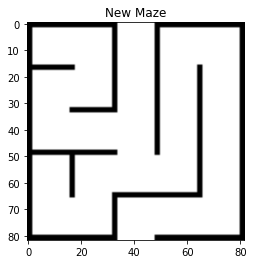

In [4]:
# Chrome driver path
PATH = 'D:\Program Files (x86)\chromedriver.exe'

# Download path
DOWNLOAD_PATH = 'D:\Github\Work\RL-Maze\maze'

# Instantiate the class
agent = MazeSolver(PATH, DOWNLOAD_PATH)

In [5]:
agent.environment.shape

(82, 82)

### Print out the maze
Terminal state is represented with 7s

*Note: The black squares represent both the walls and the path of the agent. I attempted to use something else to represent the path, but it altered the format of the maze because of the different sizes*

In [6]:
def plot_path(maze):
    emojis ={
        0: emoji.emojize(':white_medium_square:', use_aliases=True),
        1: emoji.emojize(':black_medium_square:', use_aliases=True),
        5: emoji.emojize(':black_medium_square:', use_aliases=True),
        7: emoji.emojize(':round_pushpin:', use_aliases=True)
    }
    
    for r in range(82):
        for c in range(82):
            print(emojis[maze[r,c]], end='')
        print()

In [7]:
plot_path(agent.reset)

◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼📍📍📍📍📍📍📍📍📍📍📍📍📍📍◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼📍📍📍📍📍📍📍📍📍📍📍📍📍📍◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻

### Print environment to text file
Since the real environment does not look well when printed out in the Jupyter Notebook, this piece of code will write it to a text file.

In [8]:
file = open("actual-environment.txt", "w")

for r in range(82):
    for c in range(82):
        file.write(str(agent.environment[r,c]))
    file.write("\n")
    
file.close()

## Useful Functions

In [9]:
def combine(row, col):
    return row*100+col

def separate(combined):
    return combined//100, combined%100
   
def e_greedy(epsilon, Q, state):
    idx = np.where(Q[:,0]==state)
    Q_idx = Q[idx][0][1:]
    
    if np.random.random() >= epsilon:
        action = np.argmax(Q_idx)
    else:
        action = np.random.randint(4)
        
    return action

**Create list of all the environment states.**

*Note: this list contains the walls since the environment changes with each instance of the `MazeSolver` class, but they are not used*

In [10]:
states = []

for row in range(82):
    for col in range(82):
        states.append(combine(row, col))

len(states)

6724

## Sarsa (on-policy TD control)

In [11]:
def run_sarsa(epsilon, alpha, gamma, max_steps, n_iters, distance):
    # Initialize Q(S,A)
    Q = np.zeros((len(states), 5))

    # Set states as the first column
    Q[:, 0] = states
    
    for _ in tqdm(range(n_iters)):
        # Reset the path environment to see the agent's path
        agent.reset_env()
        
        # Starting state 
        row = 80
        col = 41
        state = combine(row, col)

        # Choose A from S using e-greedy policy
        action = e_greedy(epsilon, Q, state)

        for i in range(max_steps):
            # Take action A, observe R, S'
            next_state, r = agent.step(state, action)

            # Choose A' from S' using e-greedy policy
            next_action = e_greedy(epsilon, Q, next_state)

            # Get Q(S,A)
            Q_idx = np.where(Q[:,0]==state)[0]
            current_Q = Q[Q_idx, action+1][0]

            # Get Q(S',A')
            next_Q_idx = np.where(Q[:,0]==next_state)[0]
            next_Q = Q[next_Q_idx, next_action+1][0]

            # Update Q
            # Q(S,A) = Q(S,A) + alpha*[R + gamma*Q(S',A')) - Q(S,A)]
            Q[Q_idx, action+1] = current_Q + alpha*(r + gamma*next_Q - current_Q)

            # End episode if terminal state is reached
            if r == 50:
                distance.append(i)
                break
            
            elif i == max_steps:
                distance.append(i)
                break
                
            # Else, continiue episode
            else:
                state = next_state
                action = next_action

### After 1 Episode

In [12]:
epsilon = 0.01
alpha = 0.9
gamma = 1
max_steps = 200_000
n_iters = 1
distance = []

run_sarsa(epsilon, alpha, gamma, max_steps, n_iters, distance)

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


In [13]:
plot_path(agent.path)

◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼📍📍📍📍📍📍📍📍📍📍📍📍📍📍◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼📍📍📍📍📍📍📍📍📍📍📍📍◼📍◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻

### After 5,000 Episodes

In [14]:
epsilon = 0.01
alpha = 0.9
gamma = 1
max_steps = 200_000
n_iters = 5000
distance = []

run_sarsa(epsilon, alpha, gamma, max_steps, n_iters, distance)

100%|██████████| 5000/5000 [02:05<00:00, 39.69it/s]


**Show the minimum distance calculated during the episodes**

In [15]:
print(f'Minimum distance was {min(distance)} steps at episode {np.argmin(distance)+1}.')

Minimum distance was 212 steps at episode 3325.


**Plot Total Steps Taken Over Each Episode**

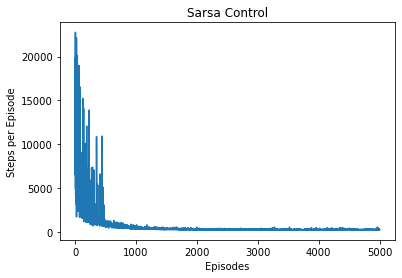

In [16]:
plt.plot(np.arange(1, len(distance)+1), distance)
plt.xlabel('Episodes')
plt.ylabel('Steps per Episode')
plt.title('Sarsa Control')
plt.show()

**Show the last path taken**

In [17]:
plot_path(agent.path)

◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼📍📍📍📍📍📍📍📍📍📍📍📍📍📍◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼📍📍📍📍📍📍📍📍📍📍📍📍◼📍◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻

## Tabular Dyna-Q

In [18]:
def run_dyna_Q(epsilon, alpha, gamma, n_iters, n_step, all_distances, path):    
    # Initialize Q(S,A)
    Q = np.zeros((len(states), 5))

    # Set states as the first column
    Q[:, 0] = states

    # Initialize Model(S,A)
    model = np.zeros((len(states), 5))

    # Set states as the first column
    model[:, 0] = states
    
    # Record the number of steps taken for each run
    distances = []

    for _ in tqdm(range(n_iters)):
        # Reset the printed environment to see the agent's path
        agent.reset_env()
        
        # Keep track of previously visited states and actions
        SA = []

        # Starting state 
        row = 80
        col = 41
        state = combine(row, col)
        
        terminal = False
        steps = 0

        while not terminal:
            # Take an action
            action = e_greedy(epsilon, Q, state)

            # Save state, action pair
            SA.append((state, action))

            # Take action A and observe resultant reward and next state
            next_state, r = agent.step(state, action)

            # Get Q(S,A)
            Q_idx = np.where(Q[:,0]==state)[0]
            current_Q = Q[Q_idx, action+1][0]

            # Get maxQ(S',a)
            Q_next_max = max(Q[np.where(Q[:,0]==next_state)][0][1:])

            # Update Q
            # Q(S,A) = Q(S,A) + alpha*[R + gamma*maxQ(S',a) - Q(S,A)]
            Q[Q_idx, action+1] = current_Q + alpha*(r + gamma*Q_next_max - current_Q)

            # Update Model
            model_idx = np.where(model[:,0]==state)[0]
            model[model_idx, action+1] = next_state*60+np.abs(r)

            # Do planning steps on the model
            for _ in range(n_step):
                # Random previously observed state and reward
                state_m, action_m = random.choice(SA)

                # Get S',R from Model
                model_idx = np.where(model[:,0]==state_m)[0]
                num = model[model_idx, action_m+1]
                next_state_m, r_m = (num//60)[0], (num%60)[0]
                r_m = -r_m if r_m < 50 else r_m

                # Get Q(S,A)
                Q_idx = np.where(Q[:,0]==state_m)[0]
                current_Q = Q[Q_idx, action_m+1][0]

                # Get maxQ(S',a)
                Q_next_max = max(Q[np.where(Q[:,0]==next_state_m)][0][1:])

                # Update Q
                # Q(S,A) = Q(S,A) + alpha*[R + gamma*maxQ(S',a) - Q(S,A)]
                Q[Q_idx, action_m+1] = current_Q + alpha*(r_m + gamma*Q_next_max - current_Q)


            # Finish current episode if reached terminal state
            if r == 50:
                distances.append(steps)  # Save the number of steps it took
                terminal = True
                
            # Else, continue the episode
            else:
                steps+=1
                state = next_state
        
    
    all_distances.append(distances)  # Save the list of distances
    path.append(agent.path)          # Save the last path taken

### After 1 Episode

In [19]:
epsilon = 0.01
alpha = 0.9
gamma = 1
n_iters = 1
n = 25
all_distances = []
path = []

run_dyna_Q(epsilon, alpha, gamma, n_iters, n, all_distances, path)

100%|██████████| 1/1 [00:15<00:00, 15.75s/it]


In [20]:
for p in path:
    print(f'After {n_iters} episodes using {n} planning steps')
    plot_path(p)
    print('\n')

After 1 episodes using 25 planning steps
◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼📍📍📍📍📍📍📍📍📍📍📍📍📍📍◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼📍📍📍📍📍📍📍📍📍📍📍📍📍◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻

### After 300 Episodes

In [21]:
epsilon = 0.01
alpha = 0.9
gamma = 1
n_iters = 300
ns = [5, 10, 25, 50]
all_distances = []
path = []

for n in ns:
    run_dyna_Q(epsilon, alpha, gamma, n_iters, n, all_distances, path)

100%|██████████| 300/300 [22:42<00:00,  4.54s/it] 


**Print the minumum steps taken over 300 episodes for each value of n planning steps**

In [22]:
for n, dist in zip(ns, all_distances):
    print(f'Minimum distance was {min(dist)} using {n} planning steps.')

Minimum distance was 576 using 5 planning steps.
Minimum distance was 634 using 10 planning steps.
Minimum distance was 408 using 25 planning steps.
Minimum distance was 411 using 50 planning steps.


**Plot the number of steps taken over time for each n planning steps**

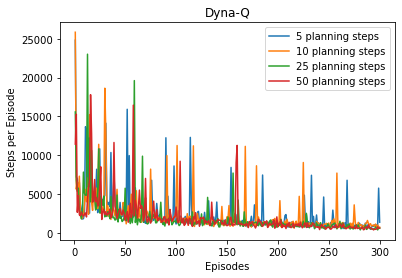

In [23]:
for n, dist in zip(ns, all_distances):
    x = np.arange(1, len(dist)+1)
    plt.plot(x, dist, label=f"{n} planning steps")

plt.xlabel('Episodes')
plt.ylabel('Steps per Episode')
plt.title('Dyna-Q')
plt.legend()
plt.show()

**Print the last path taken for each n planning steps**

In [24]:
for n, p in zip(ns, path):
    print(f'After {n_iters} episodes using {n} planning steps')
    plot_path(p)
    print('\n')

After 300 episodes using 5 planning steps
◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼📍📍📍📍📍📍📍📍📍📍📍📍📍📍◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼📍📍📍📍📍📍📍📍📍📍📍📍📍◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◻◻◻◻◻◻◻◻◻

◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◼◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◻◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◼◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◻◼◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◼◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◻◼◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◼◼◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◼◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◼◼◼◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◼◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◼◼◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◼◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◻◻◼◼◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◼◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◼◼◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◼◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◼◼◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◼◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◻◼◼◼◼◼◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◼◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◼◻◼◼◼◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◼◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◼◻◻◼◼◼◻◼◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻

◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◻◼◼◼◻◻◻◻◻◻◻◼◼◻◻◼◼◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◻◼◻◻◻◻◻◻◻◻◻◼◼◻◻◼◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◼◼◻◻◻◻◻◻◻◻◻◼◼◻◼◼◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◼◼◻◻◻◻◻◻◻◻◻◻◼◼◻◼◼◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◼◼◻◻◻◻◻◻◻◻◻◻◼◼◻◻◼◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◼◻◻◻◻◻◻◻◻◻◻◼◼◻◻◼◼◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◼◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◼◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◼◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◼◼◻◻◻◻◻◻◻◻◻◻◼◼◻◼◼◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◼◻◻◻◻◻◻◻◻◻◻◻◼◼◻◼◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◼◼◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◼◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻

◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◻◻◻◻◻◻◻◼◼◼◼◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◻◻◻◻◻◻◻◻◻◼◼◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◻◻◼◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◼◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◼◼◼◼◻◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◼◼◼◻◼◼◼◼◼◼◼◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◻◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◼◼◼◻◻◼◼◼◼◼◼◼◼◼◼◼◻◻◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◻◼◼◻◻◼◻◻◼◻◼◻◻◼◼◼◼◼◼◼◼◼◻◻◻◻◼◼◼◼◼◼◻◼◼◻◻◻◼◻◻◻◻◻◻◻◻◻◻◼◼
◼◼◻◻